Attempting to download AAPL data...


/tmp/ipython-input-4111459657.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Download successful.
2558/2558 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 6.8005e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Root Mean Squared Error: 13.4032


/tmp/ipython-input-4111459657.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


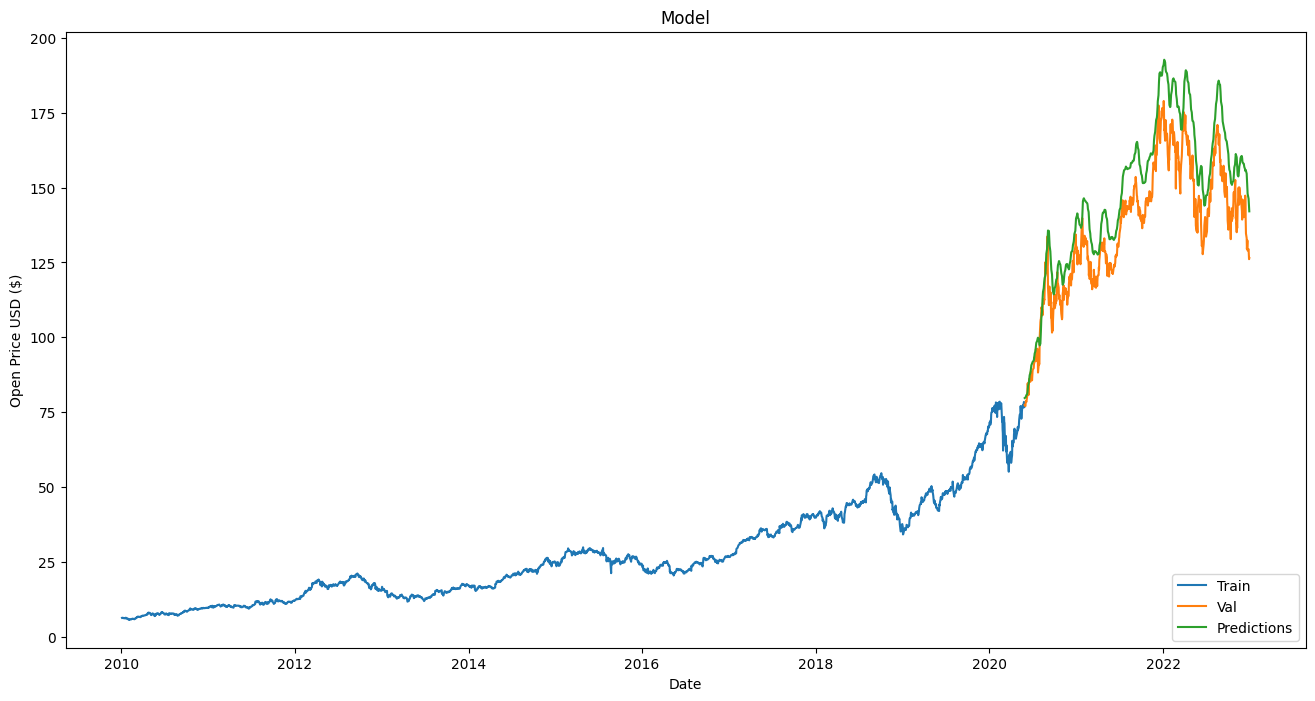

                  Open  Predictions
Date                               
2020-05-29   77.420283    79.747475
2020-06-01   77.056510    79.933624
2020-06-02   77.784026    80.053482
2020-06-03   78.732230    80.199844
2020-06-04   78.666755    80.445572
...                ...          ...
2022-12-23  128.974267   147.889252
2022-12-27  129.427431   146.286819
2022-12-28  127.742842   144.851196
2022-12-29  126.087812   143.460815
2022-12-30  126.501579   142.048553

[654 rows x 2 columns]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def fetch_stock_data(ticker, start_date, end_date):
    try:
        print(f"Attempting to download {ticker} data...")
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError("Downloaded data is empty.")

        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        print("Download successful.")
        return data
    except Exception as e:
        print(f"Warning: Could not download data ({e}). Generating synthetic data instead.")
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        np.random.seed(42)
        values = np.random.randn(len(dates)).cumsum() + 150
        data = pd.DataFrame(data={'Open': values}, index=dates)
        data.index.name = 'Date'
        return data

ticker = 'AAPL'
data = fetch_stock_data(ticker, start_date='2010-01-01', end_date='2023-01-01')

if 'Date' in data.columns:
    data = data.sort_values('Date')

if 'Open' not in data.columns:
    print("Column 'Open' not found. Using the first column available.")
    data = data.iloc[:, [0]]
    data.columns = ['Open']
else:
    data = data.filter(['Open'])

dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse:.4f}')

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

print(valid)

2025-12-02 00:31:27.426273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 00:31:27.496492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 00:31:28.885577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Attempting to download AAPL data...


/tmp/ipykernel_328226/1315102022.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Download successful.


I0000 00:00:1764615692.514610  328226 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1200 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/navit/DAV_LAB/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-12-02 00:31:36.173309: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - loss: 4.8781e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Root Mean Squared Error: 12.9847


/tmp/ipykernel_328226/1315102022.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


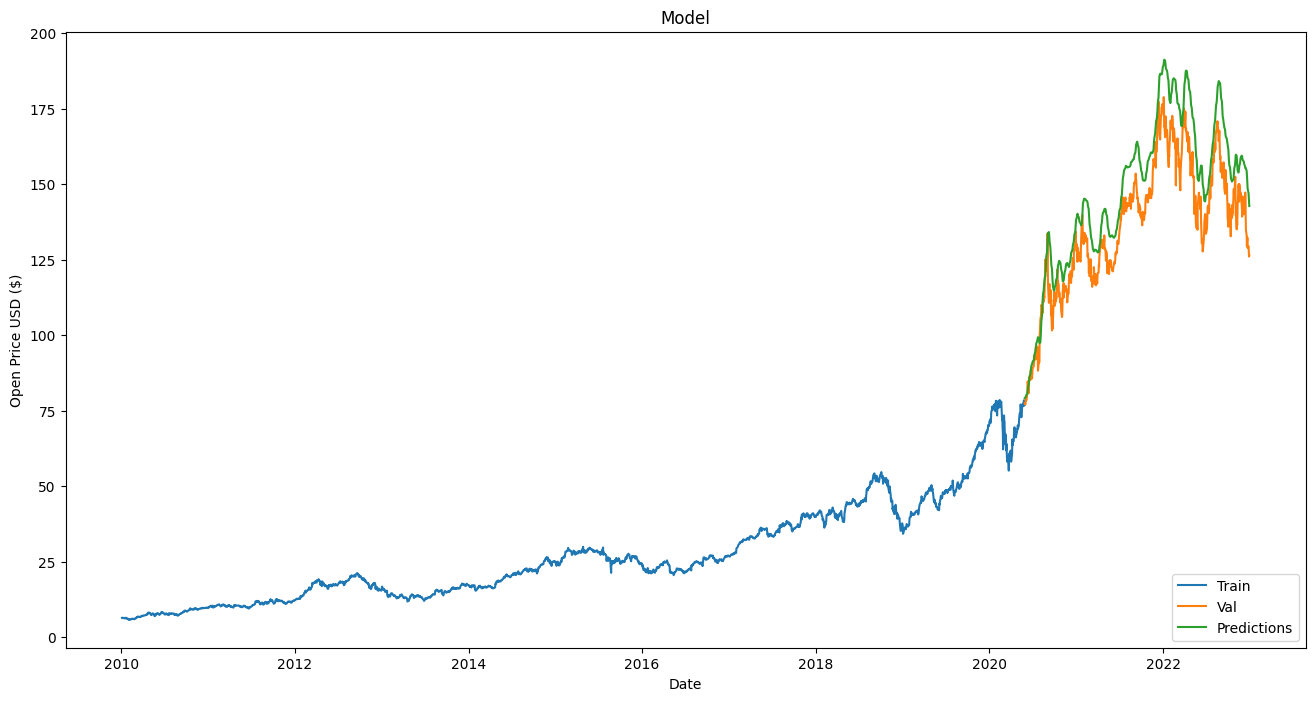

                  Open  Predictions
Date                               
2020-05-29   77.420268    79.169868
2020-06-01   77.056510    79.398315
2020-06-02   77.784048    79.564606
2020-06-03   78.732237    79.736046
2020-06-04   78.666732    79.972206
...                ...          ...
2022-12-23  128.974267   148.572586
2022-12-27  129.427431   147.035217
2022-12-28  127.742834   145.602310
2022-12-29  126.087797   144.201859
2022-12-30  126.501549   142.790451

[654 rows x 2 columns]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def fetch_stock_data(ticker, start_date, end_date):
    try:
        print(f"Attempting to download {ticker} data...")
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError("Downloaded data is empty.")

        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        print("Download successful.")
        return data
    except Exception as e:
        print(f"Warning: Could not download data ({e}). Generating synthetic data instead.")
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        np.random.seed(42)
        values = np.random.randn(len(dates)).cumsum() + 150
        data = pd.DataFrame(data={'Open': values}, index=dates)
        data.index.name = 'Date'
        return data

ticker = 'AAPL'
data = fetch_stock_data(ticker, start_date='2010-01-01', end_date='2023-01-01')

if 'Date' in data.columns:
    data = data.sort_values('Date')

if 'Open' not in data.columns:
    print("Column 'Open' not found. Using the first column available.")
    data = data.iloc[:, [0]]
    data.columns = ['Open']
else:
    data = data.filter(['Open'])

dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse:.4f}')

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

print(valid)